In [148]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from scipy.spatial.distance import (cdist)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.datasets import make_blobs

In [149]:
data = load_iris()

In [150]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)

In [151]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [152]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [153]:
df

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [154]:
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=data.feature_names)

In [155]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [156]:
class KMeans:
    def __init__(self, n_clusters: int, max_iterations: int):
        self._k = n_clusters  # число кластеров
        self.max_iter = max_iterations
        
    def _get_distances(self, X: pd.DataFrame) -> np.ndarray:
        distances = cdist(X, self.centroids, metric='sqeuclidean')
        return distances
    
    def _get_labels(self, distances: np.ndarray):
        labels = np.argmin(distances, axis=1)
        return labels
    
    def _get_wcss(self, distances):
        return np.sum(np.min(distances, axis=1))
    
    def fit(self, X: pd.DataFrame):
        n_samples, n_features = X.shape
        self.centroids = np.random.random((self._k, n_features))
        wcss = []
        for _ in range(self.max_iter):
            distances = self._get_distances(X)
            labels = self._get_labels(distances)
            wcss.append(self._get_wcss(distances))
            for i in range(self._k):
                self.centroids[i] = np.mean(X[labels == i], axis=0)
        return wcss
    
    def predict(self, X: pd.DataFrame):
        distances = self._get_distances(X)
        labels = self._get_labels(distances)
        return labels
        
        

In [157]:
k_means = KMeans(3, 1000)

<Axes: >

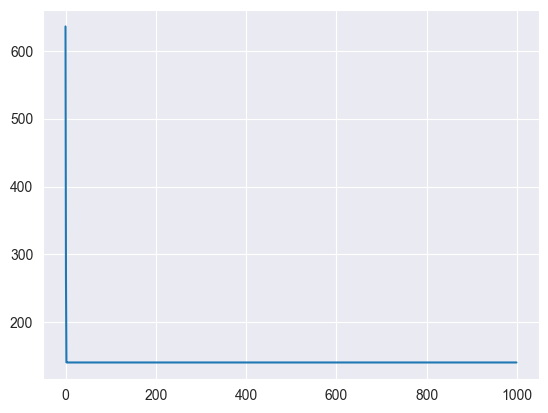

In [158]:
wcss = k_means.fit(df)
sns.lineplot(x=range(len(wcss)), y=wcss)

In [159]:
df['labels'] = k_means.predict(df)

Text(0, 0.5, 'Feature 2')

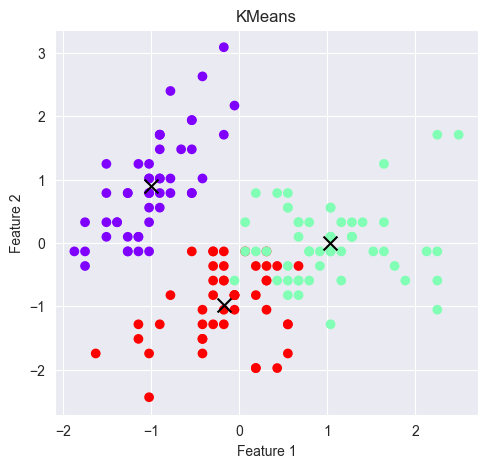

In [160]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.2)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['labels'], cmap="rainbow")
plt.scatter(k_means.centroids[:, 0], k_means.centroids[:, 1], marker="x", color="black", s=100)
plt.title("KMeans")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")


In [161]:
class DBSCAN:
    @staticmethod
    def get_neighbors(point_indx, eps, X):
        X = X.reset_index()
        dist_matrix = pd.DataFrame(cdist([X.iloc[point_indx, 1:-1].tolist()], X.iloc[:, 1:-1]).T, columns=['distance'])
        return X[dist_matrix['distance'] <= eps]['index']
    
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
    
    def fit_predict(self, X: pd.DataFrame):
        C = 0
        X['labels'] = -1
        for indx in df.index:
            if df.loc[indx, 'labels'] != -1:
                continue
            neighbors = self.get_neighbors(indx, self.eps, X)
            if len(neighbors) < self.min_samples:
                df.loc[indx, 'labels'] = 0
                continue
            C += 1
            df.loc[indx, 'labels'] = C
            neighbors = neighbors.drop(indx).values
            for neighbor in neighbors:
                if df.loc[neighbor, 'labels'] == 0:
                    df.loc[neighbor, 'labels'] = C
                if df.loc[neighbor, 'labels'] != -1:
                    continue
                df.loc[neighbor, 'labels'] = C
                new_neighbors = set(self.get_neighbors(neighbor, self.eps, X))
                if len(new_neighbors) >= self.min_samples:
                    neighbors = list(set(neighbors).union(new_neighbors))
        
        return X.labels

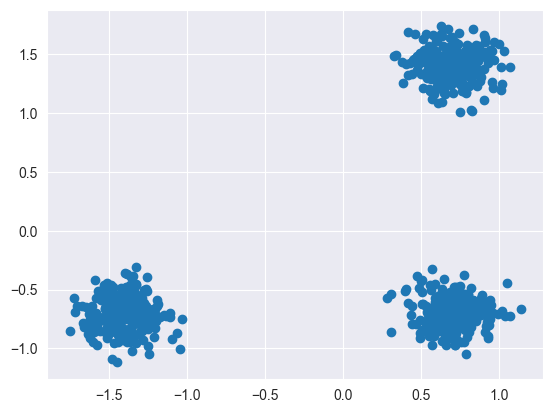

In [162]:
centers = [[3, 3], [-3, -3], [3, -3]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

df = pd.DataFrame(X)

plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.show()

In [163]:
dbscan = DBSCAN(eps=0.7, min_samples=10)

df['labels'] = dbscan.fit_predict(df)

df.labels.value_counts()

labels
1    250
2    250
3    250
Name: count, dtype: int64

Text(0, 0.5, 'Feature 2')

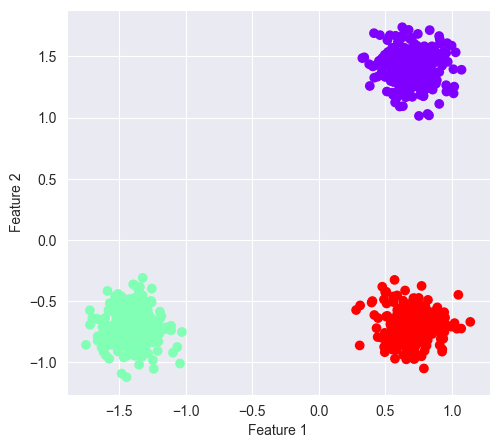

In [164]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.2)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df['labels'], cmap="rainbow")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
